### Libraries

In [ ]:
# pip install -U pip setuptools wheel

In [ ]:
# pip install -U spacy

In [ ]:
# !python -m spacy download en

In [ ]:
# pip install --upgrade spacy

In [ ]:
# pip install ekphrasis -U

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize.casual import TweetTokenizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from ekphrasis.classes.segmenter import Segmenter
# import spacy

In [ ]:
# nlp = spacy.load("en_core_web_md")

### Load dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/MyDrive/twitter/

/content/drive/MyDrive/twitter


In [22]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1534944,4,2178886650,Mon Jun 15 08:20:44 PDT 2009,NO_QUERY,tobsters,Happy #squarespace Monday to all...
503507,0,2187861295,Mon Jun 15 20:55:12 PDT 2009,NO_QUERY,WtlEliCash,@williamtprice We start recording tomorrw but...
234351,0,1979567657,Sun May 31 03:36:17 PDT 2009,NO_QUERY,helen_lo,Now I'm sucked in to Mary Whitehouse. Will ha...
49733,0,1678242361,Sat May 02 06:02:33 PDT 2009,NO_QUERY,cutiedel,What ever I do I just think the moment again a...
218502,0,1976183522,Sat May 30 16:46:11 PDT 2009,NO_QUERY,misschris555,chicago tomorrow flying alone. xanax. yes.


In [23]:
df = df[['text', 'target']]
df['target'] = df['target'].replace(4, 1)

<ipython-input-23-1f5c8535f2ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].replace(4, 1)


### Plots n stuff

In [24]:
print('Dataset size:', len(df))
print("-----------------------")
print(df.shape)
print("-----------------------")
print(df.dtypes)

Dataset size: 1600000
-----------------------
(1600000, 2)
-----------------------
text      object
target     int64
dtype: object


In [25]:
np.sum(df.isnull().any(axis=1))

0

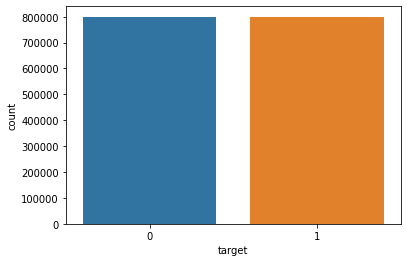

In [27]:
sns.countplot(x='target', data=df)

### Preprocessing

In [28]:
print(df['target'].unique())

[0 1]


In [29]:
df_negative = df[df['target'] == 0]
df_positive = df[df['target'] == 1]

In [30]:
df = pd.concat([df_negative, df_positive])

In [31]:
tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
df_tmp = df['text'].apply(tokenizer.tokenize)

In [32]:
seg_tw = Segmenter(corpus="twitter")

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [33]:
def separate_hashtags(s):
    '''Removes the hashtag sign and segments the hashtag text.'''
    hashtags = []
    
    l = []
    for i, s_i in enumerate(s):
        if s_i.startswith('#'):
            tmp = tokenizer.tokenize(seg_tw.segment(s_i.replace('#', '')))
            l.extend(tmp)
        else:
            l.append(s_i)
    return l
            
df_tmp = df_tmp.apply(separate_hashtags)

In [34]:
def preprocess_words(s):
    '''
    Removes tags, links, smiley faces, | signs, stopwords and changes the case to lower.
    '''
    ret_list = []

    smiley_regex = r'([\:\;\=][()PDO\/\]\[p|]+)+'
    
    is_tag = lambda w: w.startswith('@')
    is_vertical_line = lambda w: w.startswith('|')
    is_link = lambda w: w.startswith("http") or w.startswith("https")
    is_hashtag = lambda w: w.startswith("#")
    is_smiley = lambda w: re.match(smiley_regex, w)

    w2 = []
    for i, w in enumerate(s):
        if is_tag(w) or is_link(w) or is_vertical_line(w):
            continue

        elif is_hashtag(w):
            w_tmp = w.replace('#', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

        elif is_smiley(w):
            w_tmp = re.sub(smiley_regex, '', w)
            if w_tmp != '':
                lower_append(w_tmp, w2)

        else:
            w_tmp = w.replace('#', '')
            w_tmp = w_tmp.replace('|', '')
            w_tmp = w_tmp.replace('_', '')
            w_tmp = w_tmp.replace('...', '')
            if w_tmp != '':
                lower_append(w_tmp, w2)

    return ' '.join([i for i in w2 if len(i) > 2])

def lower_append(w, l):
    l.append(w.lower())

df['clean_text'] = df_tmp.apply(preprocess_words)

In [35]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['clean_text']= df['clean_text'].apply(lambda x: cleaning_punctuations(x))


In [36]:
def remove_tuple_characters(s):
    return [re.sub(r'(.)\1{2,}', r'\1', w) for w in s]

df['clean_text'] = df[['clean_text']].apply(remove_tuple_characters)

print(df.shape)
df.head(15)

(1600000, 3)


,text,target,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,aw thats bummer you shoulda got david carr thi...
1,is upset that he can't update his Facebook by ...,0,upset that cant update his facebook texting an...
2,@Kenichan I dived many times for the ball. Man...,0,dived many times for the ball managed save the...
3,my whole body feels itchy and like its on fire,0,whole body feels itchy and like its fire
4,"@nationwideclass no, it's not behaving at all....",0,its not behaving all im mad why here because c...
5,@Kwesidei not the whole crew,0,not the whole crew
6,Need a hug,0,need hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,0,hey long time see yes rains bit only bit lol i...
8,@Tatiana_K nope they didn't have it,0,nope they didnt have
9,@twittera que me muera ?,0,que muera


### Stemming

In [38]:
df.to_csv('tmp.csv')

In [39]:
import nltk
st = PorterStemmer()
def stem_text(s):
  return [st.stem(word) for word in s.split()]

df['stemmed_text'] = df['clean_text'].apply(lambda x: stem_text(x))
df['stemmed_text'].head()

0    [aw, that, bummer, you, shoulda, got, david, c...
1    [upset, that, cant, updat, hi, facebook, text,...
2    [dive, mani, time, for, the, ball, manag, save...
3      [whole, bodi, feel, itchi, and, like, it, fire]
4    [it, not, behav, all, im, mad, whi, here, beca...
Name: stemmed_text, dtype: object

In [40]:
df['stemmed_text'].tail()

1599995    [just, woke, have, school, the, best, feel, ever]
1599996    [thewdbcom, veri, cool, hear, old, walt, inter...
1599997    [are, you, readi, for, your, mojo, makeov, ask...
1599998    [happi, 38th, birthday, boo, al, time, tupac, ...
1599999                            [happi, chariti, tuesday]
Name: stemmed_text, dtype: object

In [41]:
df.shape

(1600000, 4)

### Lemmatization

In [42]:
# def lemmatize(s):
#     '''Lemmatizes the words in the sentences and returns them if theyre not stopwords or punctuation'''
#     return [[w.lemma_.lower() for w in nlp(s_i) if w.lemma_.lower() not in nlp.Defaults.stop_words and not w.is_punct] for s_i in s]

# df['lemmas'] = df[['clean_text']].apply(lemmatize)
lm = WordNetLemmatizer()
def lemmatize(s):
    return [lm.lemmatize(word) for word in s.split()]
    
df['lemmas'] = df['clean_text'].apply(lambda x: lemmatize(x))
df['lemmas'].head()

0    [aw, thats, bummer, you, shoulda, got, david, ...
1    [upset, that, cant, update, his, facebook, tex...
2    [dived, many, time, for, the, ball, managed, s...
3      [whole, body, feel, itchy, and, like, it, fire]
4    [it, not, behaving, all, im, mad, why, here, b...
Name: lemmas, dtype: object

In [43]:
df.tail()

,text,target,clean_text,stemmed_text,lemmas
1599995,Just woke up. Having no school is the best fee...,1,just woke having school the best feeling ever,"[just, woke, have, school, the, best, feel, ever]","[just, woke, having, school, the, best, feelin..."
1599996,TheWDB.com - Very cool to hear old Walt interv...,1,thewdbcom very cool hear old walt interviews,"[thewdbcom, veri, cool, hear, old, walt, inter...","[thewdbcom, very, cool, hear, old, walt, inter..."
1599997,Are you ready for your MoJo Makeover? Ask me f...,1,are you ready for your mojo makeover ask for d...,"[are, you, readi, for, your, mojo, makeov, ask...","[are, you, ready, for, your, mojo, makeover, a..."
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1,happy 38th birthday boo al time tupac amaru sh...,"[happi, 38th, birthday, boo, al, time, tupac, ...","[happy, 38th, birthday, boo, al, time, tupac, ..."
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,1,happy charity tuesday,"[happi, chariti, tuesday]","[happy, charity, tuesday]"


In [44]:
print(df.at[200000, "clean_text"])
print(df.at[200000, "stemmed_text"])
print(df.at[200000, "lemmas"])

cant believe have wait another months for phone contract end im bored now the month contract would have run out
['cant', 'believ', 'have', 'wait', 'anoth', 'month', 'for', 'phone', 'contract', 'end', 'im', 'bore', 'now', 'the', 'month', 'contract', 'would', 'have', 'run', 'out']
['cant', 'believe', 'have', 'wait', 'another', 'month', 'for', 'phone', 'contract', 'end', 'im', 'bored', 'now', 'the', 'month', 'contract', 'would', 'have', 'run', 'out']


In [45]:
df.to_csv('twitter_lemmas.csv')

In [46]:
print(df.shape)
df = df[df['lemmas'].apply(lambda x: len(x)) > 0]
print(df.shape)

(1600000, 5)
(1595618, 5)


In [47]:
df.head()

,text,target,clean_text,stemmed_text,lemmas
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,aw thats bummer you shoulda got david carr thi...,"[aw, that, bummer, you, shoulda, got, david, c...","[aw, thats, bummer, you, shoulda, got, david, ..."
1,is upset that he can't update his Facebook by ...,0,upset that cant update his facebook texting an...,"[upset, that, cant, updat, hi, facebook, text,...","[upset, that, cant, update, his, facebook, tex..."
2,@Kenichan I dived many times for the ball. Man...,0,dived many times for the ball managed save the...,"[dive, mani, time, for, the, ball, manag, save...","[dived, many, time, for, the, ball, managed, s..."
3,my whole body feels itchy and like its on fire,0,whole body feels itchy and like its fire,"[whole, bodi, feel, itchi, and, like, it, fire]","[whole, body, feel, itchy, and, like, it, fire]"
4,"@nationwideclass no, it's not behaving at all....",0,its not behaving all im mad why here because c...,"[it, not, behav, all, im, mad, whi, here, beca...","[it, not, behaving, all, im, mad, why, here, b..."


### Train test split

In [48]:
X = df.lemmas
y = df.target

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

### Vectorization

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [51]:
tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1,2),
    max_features=500000,
)

In [52]:
# Vectorizer doesnt work with lists
def join_docs(s):
  return ' '.join(s)

X_train = X_train.apply(join_docs)
X_test = X_test.apply(join_docs)

In [53]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

### Train and evaluate

In [54]:
def evaluate_model(model):
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
#Grid search

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     79583
           1       0.81      0.83      0.82     79979

    accuracy                           0.82    159562
   macro avg       0.82      0.82      0.82    159562
weighted avg       0.82      0.82      0.82    159562



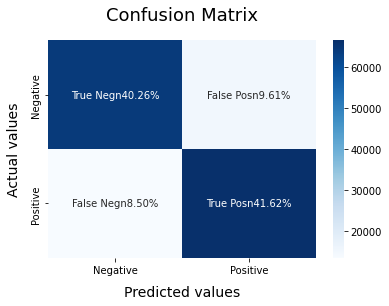

In [61]:
LRmodel = LogisticRegression(n_jobs=-1)
LRmodel.fit(X_train, y_train)
evaluate_model(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score, f1_score
print(f1_score(y_test, y_pred3))

0.8212969604036306


### Model export

In [63]:
import joblib

joblib.dump(LRmodel, 'model.joblib')

['model.joblib']

In [64]:
model_load = joblib.load('model.joblib')

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     79583
           1       0.81      0.83      0.82     79979

    accuracy                           0.82    159562
   macro avg       0.82      0.82      0.82    159562
weighted avg       0.82      0.82      0.82    159562



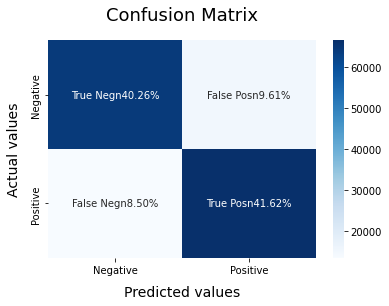

In [65]:
evaluate_model(model_load)